In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from ru_detoxification_evaluation import load_model
from ru_detoxification_metrics import evaluate_style, evaluate_cosine_similarity, evaluate_cola_relative
from transformers import AutoModel
from scipy.stats import ttest_ind, linregress
import seaborn as sns
from pingouin import ancova

In [2]:
use_cuda = True

In [3]:
style_model, style_tokenizer = load_model('s-nlp/russian_toxicity_classifier', use_cuda=use_cuda)
meaning_model, meaning_tokenizer = load_model('cointegrated/LaBSE-en-ru', use_cuda=use_cuda, model_class=AutoModel)
cola_model, cola_tokenizer = load_model('s-nlp/rubert-base-corruption-detector', use_cuda=use_cuda)

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
df = pd.read_csv('../data/input/dev.tsv', sep='\t')
df = df.fillna('')
toxic_inputs = df['toxic_comment'].tolist()
toxic_inputs_10 = [x for x in toxic_inputs for i in range(10)]

## CAIF results

In [3]:
with open('../data/rank_candidates_results/caif-rut5-base-paraphraser-10-samples.pickle', 'rb') as f:
    caif_results = pickle.load(f)
all_caif_samples = []
for i in caif_results:
    all_caif_samples.extend([candidate[2] for candidate in i])

In [47]:
caif_accuracy = evaluate_style(
    model=style_model,
    tokenizer=style_tokenizer,
    texts=all_caif_samples,
    target_label=0,  # 1 is toxic, 0 is neutral
    batch_size=32,
    verbose=True
)

  0%|          | 0/250 [00:00<?, ?it/s]

In [48]:
caif_accuracy.mean()

0.72803795

In [49]:
caif_toxic_count = (caif_accuracy.reshape(-1, 10) < 0.5).sum(axis=1)

In [50]:
caif_toxic_count.mean()

2.815

In [51]:
caif_similarity = evaluate_cosine_similarity(
    model=meaning_model,
    tokenizer=meaning_tokenizer,
    original_texts=toxic_inputs_10,
    rewritten_texts=all_caif_samples,
    batch_size=32,
    verbose=True,
)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [52]:
caif_similarity.mean()

0.53656715

In [53]:
caif_fluency = evaluate_cola_relative(
    model=cola_model,
    tokenizer=cola_tokenizer,
    original_texts=toxic_inputs_10,
    rewritten_texts=all_caif_samples,
    target_label=1,
    batch_size=32,
    verbose=True
)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [54]:
caif_fluency.mean()

0.6862003

## Plain results

In [55]:
with open('../data/rank_candidates_results/caif-alpha-0-rut5-base-paraphraser-10-samples.pickle', 'rb') as f:
    plain_results = pickle.load(f)
all_plain_samples = []
for i in plain_results:
    all_plain_samples.extend([candidate[2] for candidate in i])

In [56]:
plain_accuracy = evaluate_style(
    model=style_model,
    tokenizer=style_tokenizer,
    texts=all_plain_samples,
    target_label=0,  # 1 is toxic, 0 is neutral
    batch_size=32,
    verbose=True
)

  0%|          | 0/250 [00:00<?, ?it/s]

In [57]:
plain_accuracy.mean()

0.42077485

In [58]:
plain_toxic_count = (plain_accuracy.reshape(-1, 10) < 0.5).sum(axis=1)

In [59]:
plain_toxic_count.mean()

6.4875

In [60]:
plain_similarity = evaluate_cosine_similarity(
    model=meaning_model,
    tokenizer=meaning_tokenizer,
    original_texts=toxic_inputs_10,
    rewritten_texts=all_plain_samples,
    batch_size=32,
    verbose=True,
)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [61]:
plain_similarity.mean()

0.6312957

In [62]:
plain_fluency = evaluate_cola_relative(
    model=cola_model,
    tokenizer=cola_tokenizer,
    original_texts=toxic_inputs_10,
    rewritten_texts=all_plain_samples,
    target_label=1,
    batch_size=32,
    verbose=True
)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [63]:
plain_fluency.mean()

0.7285791

## Statistical tests

In [64]:
ttest_ind(caif_accuracy, plain_accuracy)

Ttest_indResult(statistic=54.485642282469136, pvalue=0.0)

In [65]:
ttest_ind(caif_toxic_count, plain_toxic_count)

Ttest_indResult(statistic=-24.26125897941272, pvalue=5.822118424244028e-111)

In [67]:
ttest_ind(caif_similarity, plain_similarity)

Ttest_indResult(statistic=-23.46687517352151, pvalue=9.298801310526114e-120)

In [66]:
ttest_ind(caif_fluency, plain_fluency)

Ttest_indResult(statistic=-11.527784528434534, pvalue=1.2627283686156051e-30)

## Relative toxicity

In [5]:
with open('../data/output/caif-rut5-base-paraphraser-10-samples_dev.txt', encoding='utf-8') as f:
    best_caif_samples = f.read().splitlines()

In [6]:
with open('../data/output/caif-alpha-0-rut5-base-paraphraser-10-samples_dev.txt', encoding='utf-8') as f:
    best_plain_samples = f.read().splitlines()

In [7]:
source_toxicity = evaluate_style(
    model=style_model,
    tokenizer=style_tokenizer,
    texts=toxic_inputs,
    target_label=1,  # 1 is toxic, 0 is neutral
    batch_size=32,
    verbose=True
)

  0%|          | 0/25 [00:00<?, ?it/s]

In [8]:
caif_toxicity = evaluate_style(
    model=style_model,
    tokenizer=style_tokenizer,
    texts=best_caif_samples,
    target_label=1,  # 1 is toxic, 0 is neutral
    batch_size=32,
    verbose=True
)

  0%|          | 0/25 [00:00<?, ?it/s]

In [9]:
plain_toxicity = evaluate_style(
    model=style_model,
    tokenizer=style_tokenizer,
    texts=best_plain_samples,
    target_label=1,  # 1 is toxic, 0 is neutral
    batch_size=32,
    verbose=True
)

  0%|          | 0/25 [00:00<?, ?it/s]

In [10]:
toxicity_df = pd.DataFrame()
toxicity_df['source_toxicity'] = source_toxicity
toxicity_df['caif_toxicity'] = caif_toxicity
toxicity_df['plain_toxicity'] = plain_toxicity

<AxesSubplot:xlabel='source_toxicity'>

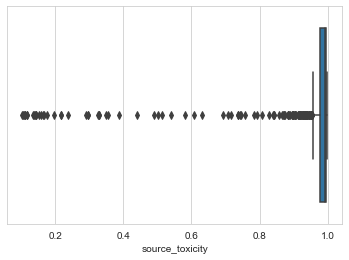

In [11]:
sns.boxplot(x='source_toxicity', data=toxicity_df)

In [12]:
data = toxicity_df

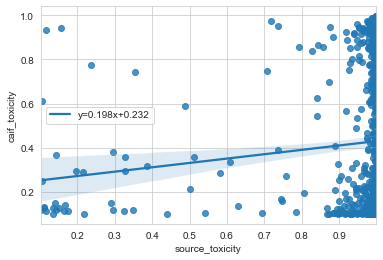

In [23]:
slope, intercept, r_value, p_value, std_err = linregress(data['source_toxicity'], data['caif_toxicity'])
ax = sns.regplot(x='source_toxicity', y='caif_toxicity', data=data,
                 line_kws={'label': f'y={round(slope, 3)}x+{round(intercept, 3)}'})
ax.legend()
fig = ax.get_figure()
fig.savefig('img/caif_toxicity.pdf')

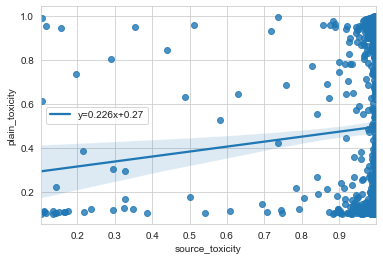

In [24]:
slope, intercept, r_value, p_value, std_err = linregress(data['source_toxicity'], data['plain_toxicity'])
ax = sns.regplot(x='source_toxicity', y='plain_toxicity', data=data,
                 line_kws={'label': f'y={round(slope, 3)}x+{round(intercept, 3)}'})
ax.legend()
fig = ax.get_figure()
fig.savefig('img/plain_toxicity.pdf')

In [25]:
toxicity_ancova_df = pd.DataFrame()
toxicity_ancova_df['model'] = ['caif'] * len(toxicity_df) + ['plain'] * len(toxicity_df)
toxicity_ancova_df['model_toxicity'] = toxicity_df['caif_toxicity'].tolist() + toxicity_df['plain_toxicity'].tolist()
toxicity_ancova_df['source_toxicity'] = toxicity_df['source_toxicity'].tolist() * 2

In [26]:
ancova(data=toxicity_ancova_df, dv='model_toxicity', covar='source_toxicity', between='model')

,Source,SS,DF,F,p-unc,np2
0,model,1.671603,1,12.817794,0.000354,0.007962
1,source_toxicity,1.802525,1,13.821699,0.000208,0.008581
2,Residual,208.269081,1597,NaN,NaN,NaN
